## Predicting Housing Prices Using Linear Regression

1 Libraries and Packages

Libraries are used in this notebook for visualization ,scaling, onehotencoding and so on but not running Linear Regression

In [563]:
# Importing all necessary libraries

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler, OneHotEncoder
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [565]:
# Reading the data files

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# copying
data_train = train
data_test = test

print("the shape of training data is:", data_train.shape)
print("the shape of testing data is:", data_test.shape)

the shape of training data is: (1460, 81)
the shape of testing data is: (1459, 80)


In [566]:
# Concatenate both data sets

train_y = data_train['SalePrice']
data_train = data_train.drop('SalePrice', axis = 1) # dropping the target variable from concatenated dataset

print("the shape of target is:", train_y.shape)
print("the shape of training data is:", data_train.shape)
print("the shape of testing data is:", data_test.shape)


the shape of target is: (1460,)
the shape of training data is: (1460, 80)
the shape of testing data is: (1459, 80)


# Exploratory Data Analysis

2.1 Investigating Variables

In [471]:
# basic eda

data_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


We have a total of 80 features

In [472]:
# Checking the count of datatypes

data_train.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

We have 43 categorical and 37 numerical variables/features

In [567]:
# checking which features are categorical and numerical

data_train.columns.to_series().groupby(data_train.dtypes).groups

{dtype('int64'): Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
       dtype='object'),
 dtype('float64'): Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object'),
 dtype('O'): Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', '

2.2 Correlations

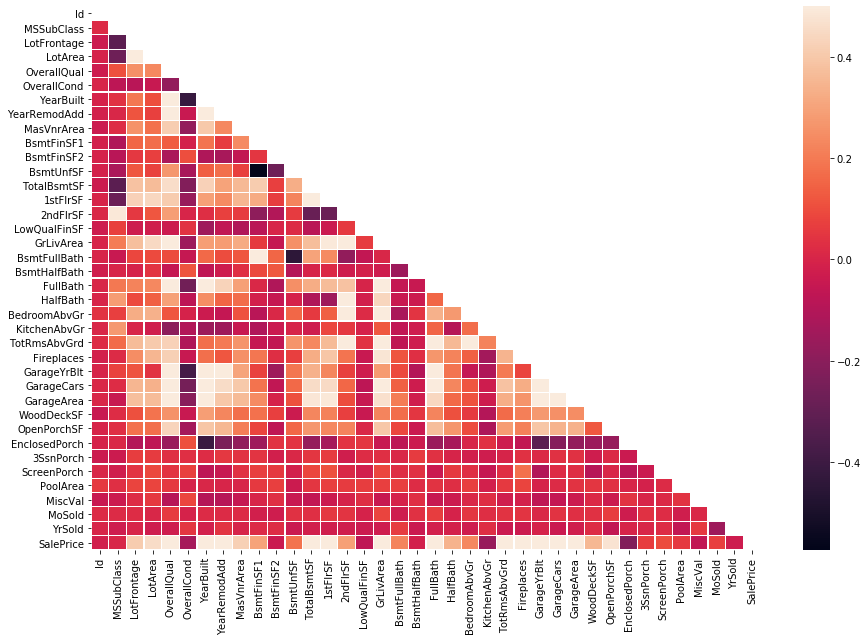

In [474]:
# checking the correlations among variables
corr = train.corr(method='spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr,vmax=.5,mask=mask, fmt='.2f',linewidths=.2);


Some Variables are highly correlated with the target variable 'SalePrice' are 'OverallQual','YearBuilt','TotalBsmtSF','GrLivArea', etc. Other observation we can infer from the heatmap is that there is some evidence of multicollinearity

2.3 Target Variable

Skewness: 1.882876

 mu = 180921.20 and sigma = 79415.29



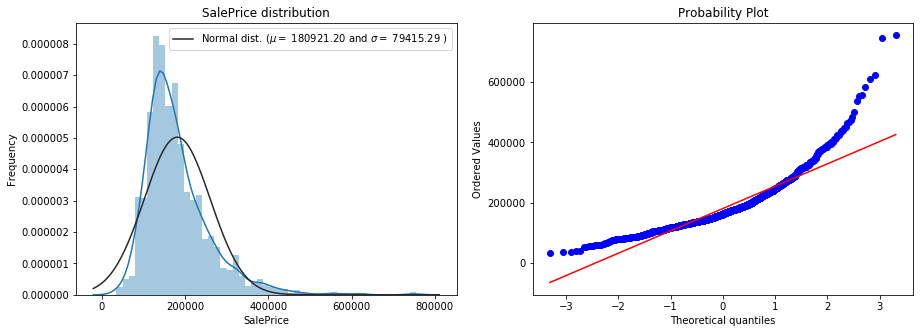

In [475]:
# Studying the target variable 'SalePrice'

# Plotting histogram and probability

fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train['SalePrice'])
print("Skewness: %f" % train_y.skew())          # checcking the skewness
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.subplot(1,2,2)
res = stats.probplot(train['SalePrice'], plot=plt)


The target variable 'SalePrice' is positively skewed. We will address this issue in later sections.

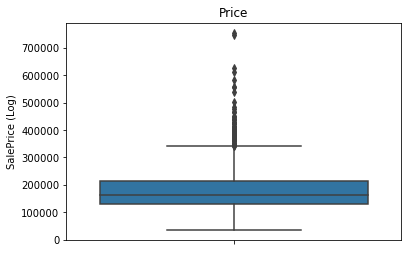

In [569]:
# displaying a Boxplot

#  checking for outliers
sns.boxplot(y = train_y)
plt.ylabel('SalePrice (Log)')
plt.title('Price');

There are a few outliers present in the dataset

# Data Preparation 

In this section, we will take all necessary steps required to lead to training the model

In [570]:
# Using a copy of dataset for preparation

data_train_pipeline = data_train.copy()
data_test_pipeline = data_test.copy()

# Concatenating both datasets
data_train_pipeline["Dataset"] = "Train"
data_test_pipeline["Dataset"] = "Test"

data_all = pd.concat([data_train_pipeline, data_test_pipeline], sort=False)
data_all = data_all.reset_index(drop=True) # reset index
print("Shape of concatenated data: {}".format(data_all.shape))

Shape of concatenated data: (2919, 81)


3.1 Missing Data

In [571]:
# Checking number of missing values

def missing_values_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

missing_values_percentage(data_all)


,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
...,...,...
CentralAir,0,0.000000
SaleCondition,0,0.000000
Heating,0,0.000000
Foundation,0,0.000000


We can observe that some features have a high percenatage of missing data. 

In [573]:
# defining few pre processing functions

# to the unique identifier 'Id'

def drop_id(df): # drop uniqueidntifier 'Id'
    df_new = df
    df_new.drop(['Id'], axis=1, inplace=True)
    return df_new

# to split numerical and categorical features

def split_num_cat(df):
    df_new = df
    numeric_features = list(df_new.select_dtypes(include=[np.number]).columns.values) #numeric features
    categ_features = list(df_new.select_dtypes(include=['object']).columns.values) #categorical features
    for col in numeric_features:
        df_new[col] = df_new[col].astype(float)     # int to float all numeric
    return df_new


data_all = drop_id(data_all)
data_all = split_num_cat(data_all)

print("the shape of dataset is {}".format(data_all.shape))


the shape of dataset is (2919, 80)


In [574]:
# Handling missing values

def imputing_missing_data(df):
    # imputing categorical features
    df_new=df
    numeric_features = list(df_new.select_dtypes(include=[np.number]).columns.values) #numeric features
    categ_features = list(df_new.select_dtypes(include=['object']).columns.values) #categorical features
    df_new[categ_features] = df_new[categ_features].apply(
        lambda x: x.fillna("None"), axis=0)  # NaNs in categorical features replaced by "None"

    # imputing numerical features
    for col in ('LotFrontage', 'GarageYrBlt', 'GarageArea', 'GarageCars'): # 4 numerical features replaced with "0"
        df_new[col].fillna(0.0, inplace=True)
        df_new[numeric_features] = df_new[numeric_features].apply(
            lambda x: x.fillna(x.median()), axis=0) # NaNs in remaining numerical features replaced by median
    return df_new


data_all = imputing_missing_data(data_all)

3.2 Feature engineering and transformations

From our reading and understanding of the features, we try to combine redundant features.

In [575]:
# combining features

def combine_features(df):
    df_new = df
    df_new['TotalSF']=df_new['TotalBsmtSF'] + df_new['1stFlrSF'] + df_new['2ndFlrSF'] # total sq ft
    df_new['Total_Bathrooms'] = (df_new['FullBath'] + (0.5 * df_new['HalfBath']) +    # no of bathrooms
                                 df_new['BsmtFullBath'] + (0.5 * df_new['BsmtHalfBath'])) 
    df_new['Total_porch_sf'] = (df_new['OpenPorchSF'] + df_new['3SsnPorch'] +         # total sq ft porch
                                  df_new['EnclosedPorch'] + df_new['ScreenPorch'] + df_new['WoodDeckSF'])
    df_new['Total_sqr_footage'] = (df_new['BsmtFinSF1'] + df_new['BsmtFinSF2'] + df_new['1stFlrSF'] # total sq ft all
                                   + df_new['2ndFlrSF'])
    df_new['YrBltAndRemod']=df_new['YearBuilt']+df_new['YearRemodAdd']
    
    return df_new

# creating boolean values for certain variables

def boolean_features(df):
    df_new = df
    df_new['haspool'] = df_new['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df_new['has2ndfloor'] = df_new['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df_new['hasgarage'] = df_new['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df_new['hasbsmt'] = df_new['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df_new['hasfireplace'] = df_new['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    return df_new


data_all = combine_features(data_all)
data_all = boolean_features(data_all)
print("the shape of dataset is:{}".format(data_all.shape))

the shape of dataset is:(2919, 90)


Now we perform feature transformations where we also check for distributions of numeric features and using boxcox tranformations to achieve normarlity in the features.

In [576]:
# feature transformations

def transform_features(df):
    df_new = df
    # converting values to string
    df_new['MSSubClass'] = df_new['MSSubClass'].apply(str)
    df_new['YrSold'] = df_new['YrSold'].astype(str)
    df_new['MoSold'] = df_new['MoSold'].astype(str)
    df_new['YrBltAndRemod'] = df_new['YrBltAndRemod'].astype(str)
    
    numeric_features = list(df_new.select_dtypes(include=[np.number]).columns.values)
    categ_features = list(df_new.select_dtypes(include=['object']).columns.values)
    
    # transform highly skewed numerical columns
    skew_features = df_new[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skew_features[skew_features > 0.5]
    skew_index = high_skew.index
    for i in skew_index:
        df_new[i] = boxcox1p(df_new[i], boxcox_normmax(df_new[i]+1))
    
    return df_new

data_all = transform_features(data_all)

We now scale all the numeric variables

In [483]:
# Scaling all numerical variables

def num_scaler(df):
    df_new = df
    numeric_features = list(df_new.select_dtypes(include=[np.number]).columns.values)
    scaler = StandardScaler() # using library 
    for col in numeric_features:
        df_new[[col]] = scaler.fit_transform(df_new[[col]])
    
    return df_new

data_all = num_scaler(data_all)

In [577]:
# checking now if we have missing data

missing_values_percentage(data_all)

,Total,Percent
hasfireplace,0,0.0
Exterior1st,0,0.0
MasVnrType,0,0.0
MasVnrArea,0,0.0
ExterQual,0,0.0
...,...,...
GarageArea,0,0.0
GarageQual,0,0.0
GarageCond,0,0.0
PavedDrive,0,0.0


Therefore now, we have sucessfully handled missing data

Skewness: 0.121347


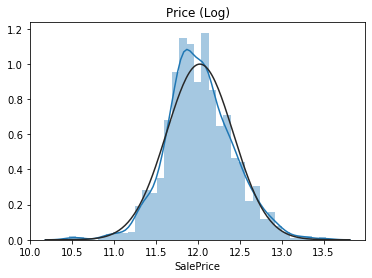

In [578]:
# transforming target variable

trans_y = np.log1p(train_y) # using log transformation to handle skewness

# plotting transformed 'SalePrice'
sns.distplot(trans_y , fit=norm);
(mu, sigma) = norm.fit(trans_y)
plt.title('Price (Log)');
print("Skewness: %f" % trans_y.skew())


The data now looks more normally distributed with skewness significantly reduced by log transformation

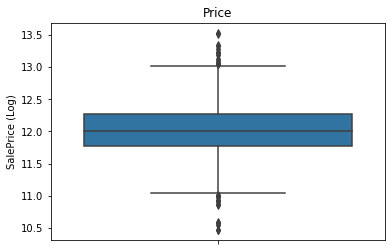

In [579]:
#  checking the outliers again

sns.boxplot(y = trans_y)
plt.ylabel('SalePrice (Log)')
plt.title('Price');


We have to geneate dummy variables for categorical data

In [580]:
# Generating dummy variables

def dummy_var(df):
    df_new = df
    df_new = pd.get_dummies(df_new)
    return df_new

data_all = dummy_var(data_all)

In [581]:
print("Total number of variables: {}.".format(data_all.shape[1]))

Total number of variables: 521.


In [582]:
# Removing those columns which have low variance

def remv_overfit(df):
    df_new = df
    overfit = []
    for i in df_new.columns:
        counts = df_new[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df_new) * 100 > 99.9: # threshold is 99.9
            overfit.append(i)
    overfit = list(overfit)
    
    # keeping columns
    try:
        overfit.remove('Dataset_Train')
        overfit.remove('Dataset_Test')
    except:
        pass
    df_new.drop(overfit, axis=1, inplace=True)
    
    return df_new

data_all = remv_overfit(data_all)

In [585]:
# checking the number of features now

print("the shape of dataset now is: {}".format(data_all.shape))

the shape of dataset now is: (2919, 477)


3.3 Forming train and test datasets

In [491]:
# Training data is extracted

data_train_trans = data_all[data_all['Dataset_Train']==1].copy()
data_train_trans.drop(['Dataset_Train'], axis=1, inplace=True)
data_train_trans.drop(['Dataset_Test'], axis=1, inplace=True)
data_train_trans =data_train_trans.reset_index(drop=True) 
print(data_train_trans.shape)

(1460, 475)


In [584]:
# Testing data is extracted
data_test_trans = data_all[data_all['Dataset_Test']==1].copy()
data_test_trans.drop(['Dataset_Train'], axis=1, inplace=True)
data_test_trans.drop(['Dataset_Test'], axis=1, inplace=True)
data_test_trans = data_test_trans.reset_index(drop=True)
print(data_test_trans.shape)

(1459, 475)


Hence, finally we have 475 features using which we will perform regression

## Linear Regression

4.1 Fitting the model

As intstructed, we will perform Linear Regression without the using any Machine Learning library. We will implement the gradient descent algorithm.

In [630]:
# Constructing the required matrices

# Matrix containing our independent variables

X = data_train_trans[:].values # filling with our features
ones = np.ones([X.shape[0],1]) # first coefficient 
X = np.concatenate((ones,X),axis=1)

# Matrix for target variable

a = trans_y.to_frame() # series to dataframe
y = a.values
theta = np.zeros([1,476]) # assigning zeros initially

# Tuning Parameters

alpha = 0.03 # learning rate
iters = 1000 # Number of iterations

In [631]:
# Defining our cost function

def compute_cost(X,y,theta):
    z = np.power(((X @ theta.T)-y),2)
    return np.sum(z)/(2 * len(X))

compute_cost(X,y,theta)

72.36870333538452

Our initial value of cost function is given above. We attempt to minimize this cost.

We now perform gradient descent to minimize this cost

In [632]:
# Defining function to perform gradient descent

def gradient_descent(X,y,theta,iters,alpha):
    cost = np.zeros(iters)
    for i in range(iters):
        theta = theta - (alpha/len(X)) * np.sum(X * (X @ theta.T - y), axis=0) # updating the parameters
        cost[i] = compute_cost(X, y, theta) # computing cost
    
    return theta,cost

# Executing

param, cost = gradient_descent(X,y,theta,iters,alpha)
minimized_cost = compute_cost(X,y,param)
print(minimized_cost)

0.013681318556551454


The cost has been significantly minimized.

Text(0, 0.5, 'Cost')

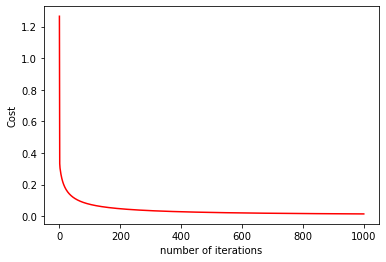

In [633]:
# Plot
fig, ax = plt.subplots()  
ax.plot(np.arange(iters), cost, 'r')  
ax.set_xlabel('number of iterations')  
ax.set_ylabel('Cost') 

Therefore, we have successfully developed a linear model.

4.2 Calculating Accuracy

In [634]:
# Evaluation metrics

# Root mean squared error

def rmse(true, estimated):
    rmse = np.sqrt(sum((true - estimated) ** 2) / len(true))
    return rmse

# R squared
def r2(true, estimated):
    mean_true = np.mean(true)
    ss_tot = sum((true - mean_true) ** 2)       # total sum of squares
    ss_res = sum((true - estimated) ** 2)       # residual sum of squares
    r2 = 1 - (ss_res / ss_tot)
    return r2


# Final estimated value of y

estimated = X.dot(param.T) 

# the accuracy of the model

print(rmse(y, estimated))
print(r2(y, estimated))


[0.16541656]
[0.82839409]


Therefore, our model is able to explain 82% of the variance in the data at the root mean squared error of 0.165